In [55]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, fftpack
from scipy.fft import fftshift
from typing import NamedTuple, Callable
from functools import reduce
import math
import time
import threading
import json

from IPython.display import set_matplotlib_formats

set_matplotlib_formats('svg')


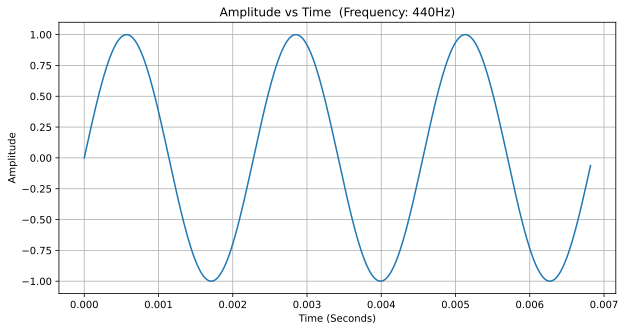

In [309]:

def show_sample(sample, duration=1, sample_rate=44100):
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(np.linspace(0, duration, math.ceil(duration * sample_rate)), sample)
        return ax
    

def spectrogram(sample, sample_rate=44100):
        X = fftpack.fft(sample)
        freqs = fftpack.fftfreq(len(sample)) * sample_rate
        fig, ax = plt.subplots(figsize=(10, 5))
#         ax.stem(freqs, np.abs(X), use_line_collection=True)
        ax.plot(np.arange(len(sample) / sample_rate), np.abs(X))
#         ax.specgram(freqs, Fs=sample_rate)
        ax.set_title('Spectrogram')
        ax.set_xlabel('Frequency in Hertz [Hz]')
        ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
        ax.set_xlim(-sample_rate / 2, sample_rate / 2)
        ax.set_ylim(-5, 110)
        return ax


class Wave:
    
    def __init__(self, frequency=440, amplitude=1, phase=0):
        self.frequency = frequency # Cycles per Second
        self.amplitude = amplitude
        self.phase = phase # Angular offset
        self.period = 1 / frequency # Seconds per cycle
        
    def sample(self, duration=1, sample_rate=44100):
        num_samples = math.ceil(sample_rate * duration)
        phase_shift = self.phase * np.pi * 2
        sampletimes =  np.linspace(0, duration, num_samples, endpoint=False)
        return (self.amplitude * np.sin(sampletimes * 2 * np.pi * self.frequency + phase_shift)).astype(np.float32)
    
    def time_amplitude_graph(self, num_periods=1, sample_rate=44100):
        duration = num_periods * self.period
        x = self.sample(duration, sample_rate=sample_rate)
        ax = show_sample(x, duration=duration, sample_rate=sample_rate)
        ax.set_title('Amplitude vs Time  (Frequency: %sHz)' % self.frequency)
        ax.set_xlabel('Time (Seconds)')
        ax.set_ylabel('Amplitude')
        ax.grid(True)
        

example_wave1 = Wave()
example_wave1.time_amplitude_graph(3)


In [308]:
import pyaudio

p = pyaudio.PyAudio()

stream = p.open(format=pyaudio.paFloat32,
                channels=1,
                rate=44100,
                output=True)

d = 0.5

p = np.linspace(440, 440, int(44100 * d))
t = np.linspace(0, 1, int(44100 * d))
# t = t * (np.linspace(0, 1, len(t)) ** 2)

# f = lambda x: (2 * x - 1) ** 3 + (x - 1) ** 2
f = lambda x: 4 * x * (1 - x)
t = p * f(t) + p

a = np.linspace(0, 0.5, int(44100 * d))
w = Wave(frequency=t, amplitude=a)

# plt.plot(w.sample(1))

# volume = 0.25

# time_step = 0.05
# # d = 2

start_time = time.time()
# for i in np.linspace(440, 880, int(d / time_step)):
#     w = Wave(frequency=i)
# #     t = min(w.period * 10, time_step)
#     stream.write((volume * w.sample(time_step)).tobytes())

stream.write((0.5 * w.sample(len(t) / 44100)).tobytes())
print(time.time() - start_time)
    
stream.stop_stream()
stream.close()

# p.terminate()


0.4402010440826416
